# Initial conditions

In [1]:
import dedalus.public as d3
import numpy as np
import matplotlib.pyplot as plt

from modules import tools


In [2]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/07_appendix/'


In [3]:
aspect = 8.

coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(
    coords['x'], size=256, bounds=(0, aspect), dealias=3/2)
zbasis = d3.ChebyshevT(
    coords['z'], size=64, bounds=(0, 1), dealias=3/2)
x, z = dist.local_grids(xbasis, zbasis)
u = dist.VectorField(coords, name='u', bases=(xbasis, zbasis))
theta = dist.Field(name='theta', bases=(xbasis, zbasis))
psi = dist.Field(name='psi', bases=(xbasis, zbasis))


In [4]:
x, z = dist.local_grids(xbasis, zbasis)

# Streamfunction satisfies these BCs:
#   psi(z=0,1) = 0
#   d(psi)/dz(z=0,1) = 0
#   psi(x=0) = psi(x=aspect)
k_base = aspect/2
psi = dist.Field(bases=(xbasis, zbasis))
psi['g'] = 0.1*(
    np.sin(2*np.pi*k_base*x/aspect)
    * (1 - (2*z - 1)**2)**2
)

# u = -d(psi)/dz, w = d(psi)/dx
u_temp = d3.Skew(d3.Gradient(psi)).evaluate()
psi.change_scales(1.)
u_temp.change_scales(1.)
u['g'] = np.copy(u_temp['g'])

# Fill temperature field with random numbers from N(0,1)
theta.fill_random(layout='g', seed=0, distribution='standard_normal')
theta['g'] *= 1e-2  # reduce magnitude of perturbation
theta['g'] *= 1 - (2*z - 1)**2  # reduce to 0 at z=0,1
theta['g'] += 0.5*(1 - 2*z)**9  # add linear profile


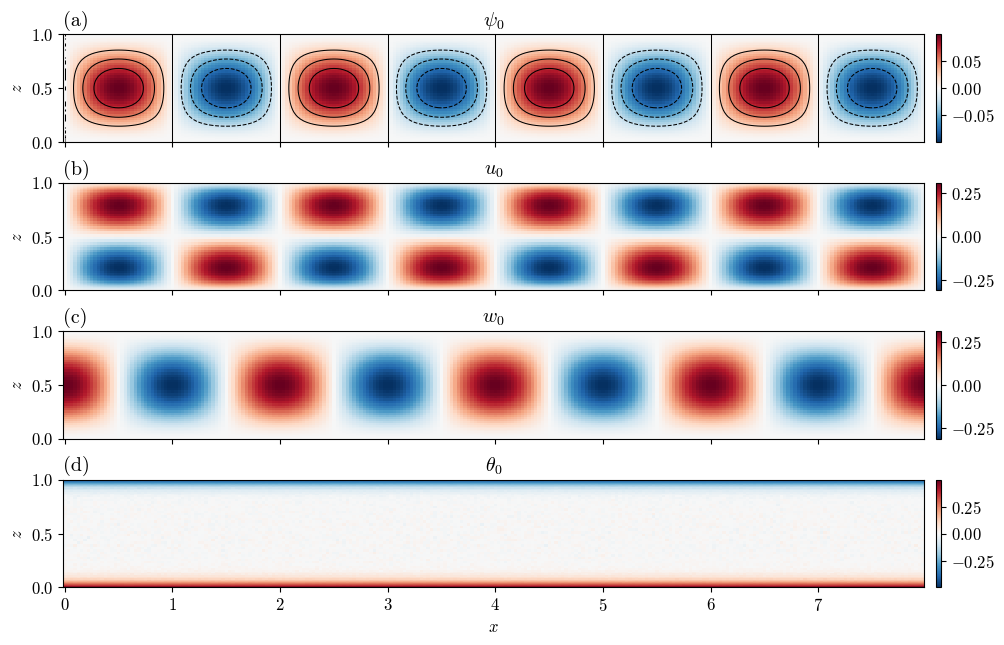

In [5]:
fig, axes = plt.subplots(4, 1, figsize=(12, 6.5), sharex=True)

mesh = axes[0].pcolormesh(x.squeeze(), z.squeeze(), psi['g'].T, cmap='RdBu_r')
axes[0].contour(
    x.squeeze(), z.squeeze(), psi['g'].T,
    colors='k', linewidths=0.75,
)
mesh.set_rasterized(True)
fig.colorbar(mesh, ax=axes[0], pad=0.01)
axes[0].set(aspect='equal', title='$\\psi_0$', ylabel='$z$')

mesh = axes[1].pcolormesh(
    x.squeeze(), z.squeeze(), u['g'][0,:,:].T, cmap='RdBu_r')
mesh.set_rasterized(True)
fig.colorbar(mesh, ax=axes[1], pad=0.01)
axes[1].set(aspect='equal', title='$u_0$', ylabel='$z$')

mesh = axes[2].pcolormesh(
    x.squeeze(), z.squeeze(), u['g'][1,:,:].T, cmap='RdBu_r')
mesh.set_rasterized(True)
fig.colorbar(mesh, ax=axes[2], pad=0.01)
axes[2].set(aspect='equal', title='$w_0$', ylabel='$z$')

mesh = axes[3].pcolormesh(
    x.squeeze(), z.squeeze(), theta['g'].T, cmap='RdBu_r')
mesh.set_rasterized(True)
fig.colorbar(mesh, ax=axes[3], pad=0.01)
axes[3].set(aspect='equal', title='$\\theta_0$', xlabel='$x$', ylabel='$z$')

fig.tight_layout()
tools.label_subplots(axes)
fig.savefig(fig_path + 'init.pdf')
